# Runs the Heat Pump Model for Multiple Scenaries across Multiple Communities

In [1]:
import sys
import numpy as np
import pandas as pd

#---- Auto-reload of modules
%load_ext autoreload
%autoreload 2

#---- Altair imports 
import altair as alt
alt.data_transformers.enable('json');   # keeps Huge data out of Notebook

## Loop through Cities Running all Scenarios

In [2]:
# Bring the heat pump calculator into the Python Path.
# This assumes that the heat-pump-calc project is present and on
# the same directory level as this heat-pump-study project.
sys.path.insert(0, '../../heat-pump-calc')
import heatpump.library as lib
import heatpump.hp_model as hpmod

In [19]:
in_base = dict(
    pce_limit=500,
    co2_lbs_per_kwh=1.5,
    exist_fuel_use=None,
    exist_heat_effic=0.8,
    exist_kwh_per_mmbtu=6.25,
    includes_dhw=False,
    includes_dryer=False,
    includes_cooking=False,
    occupant_count=3,
    hp_model_id=-1,
    low_temp_cutoff=5,
    off_months_chks=[],
    garage_stall_count=1,
    garage_heated_by_hp=False,
    bldg_floor_area=1800,
    indoor_heat_setpoint=70,
    insul_level=2,
    pct_exposed_to_hp=0.46,
    doors_open_to_adjacent=True,
    bedroom_temp_tolerance='med',
    rebate_dol=0,
    pct_financed=0,
    loan_term=10,
    loan_interest=0.05,
    hp_life=14,
    op_cost_chg=0,
    discount_rate=0.05,
    inflation_rate=0.02,
    fuel_esc_rate=0.03,
    elec_esc_rate=0.02,
)

# Inputs that need to be determined for each community
# city_id
# utility
# exist_unit_fuel_cost
# elec_use_jan
# elec_use_may
# capital_cost,
# sales_tax,

In [10]:
in_base['city_id'] = 270
in_base['utility'] = lib.util_from_id(53)
in_base['exist_heat_fuel_id'] = 4     # 4 - #1 Oil, 3 - Propane, 1 - Electricity
in_base['exist_unit_fuel_cost'] = 2.69
in_base['elec_use_jan'] = 674
in_base['elec_use_may'] = 503
in_base['capital_cost'] = 4000
in_base['sales_tax'] =  0.06

In [11]:
mod = hpmod.HP_model(**in_base)
mod.run()
mod.summary

{'fuel_unit': 'gallon',
 'fuel_desc': '#1 Oil',
 'design_heat_load': 29825.902511999997,
 'design_heat_temp': -6.159999999999997,
 'cop': 2.878791041986915,
 'hp_max_capacity_5F': 13309.359,
 'max_hp_reached': True,
 'co2_lbs_saved': 3107.6064905260464,
 'co2_driving_miles_saved': 3484.375497439699,
 'hp_load_frac': 0.769674525892312,
 'irr': 0.006809231607130428,
 'npv': -1180.2832361241437,
 'fuel_use_base': 670.4895715135682,
 'fuel_use_hp': 156.95316047548178,
 'fuel_use_chg': -513.5364110380864,
 'fuel_price_incremental': 2.8514000000000004,
 'elec_use_base': 6567.626453242359,
 'elec_use_hp': 12086.301907559753,
 'elec_use_chg': 5518.675454317394,
 'elec_rate_avg_base': 0.2744137409227546,
 'elec_rate_avg_hp': 0.25672690774176715,
 'elec_rate_incremental': 0.23567828576080563}

In [12]:
lib.city_from_id(1)

Name                                                         Anchorage
Latitude                                                        61.152
Longitude                                                     -149.864
ERHRegionID                                                          2
WAPRegionID                                                          2
ImpCost                                                              1
FuelRefer                                                        False
FuelCityID                                                         NaN
Oil1Price                                                         3.08
Oil2Price                                                          NaN
PropanePrice                                                       4.5
BirchPrice                                                         325
SprucePrice                                                        345
CoalPrice                                                          175
SteamP

In [13]:
lib.util_from_id(2)

ID                                                              2
Name                                 Anchorage ML&P - Residential
Active                                                       True
Type                                                            1
IsCommercial                                                False
ChargesRCC                                                   True
PCE                                                           NaN
CO2                                                           1.1
CustomerChg                                                 13.62
DemandCharge                                                  NaN
NameShort                                                  Anchor
Blocks          [(nan, 0.17457800125703232), (nan, nan), (nan,...
Name: 2, dtype: object

In [25]:
def find_util(city, name_part):
    """Returns the first electric utility that has a name containing 'name_part', insensitive
    to capitalization.  If no utilities match, returns the first utility listed for 
    'city'. Returns None if there are no utilities for the city. 
    """
    utils = city.ElecUtilities
    if len(utils) == 1:
        return lib.util_from_id(utils[0][1])
    if len(utils) == 0:
        return None
    else:
        for util_name, util_id in utils:
            if name_part.lower() in util_name.lower():
                return lib.util_from_id(util_id)
        return lib.util_from_id(utils[0][1])
                
def scenarios(city_id, fuel_id):
    '''Returns a list of (scenario name, input dictionary) tuples for all 
    of the scenarios being modeled for 'city_id' with the existing system
    using 'fuel_id'.
    '''
    scenarios = []
    city = lib.city_from_id(city_id)
    
    # Base Case
    sc_base = in_mid.copy()

    # Capital Cost
    # Each cost level is the same percentage above the one prior.
    # Assume highest level (level 5) is 1.6 x lowest level.
    cost_mult = 1.6 ** 0.25
    sc_base['capital_cost'] = 4000.0 * cost_mult ** (city.ImpCost - 1)
    
    # Find the residential utility for this city
    sc_base['utility'] = find_util(city, 'resid')
    
    # fuel price
    the_fuel = lib.fuel_from_id(fuel_id)
    price_col = the_fuel['price_col']
    price = np.nan_to_num(city[price_col])
    sc_base['exist_unit_fuel_cost'] = price
    
    # January and May electricity use
    sc_base['elec_use_jan'] = city.avg_elec_usage[0]
    sc_base['elec_use_may'] = city.avg_elec_usage[4]
    
    # Sales Tax
    sc_base['sales_tax'] = np.nan_to_num(city.MunicipalSalesTax) + np.nan_to_num(city.BoroughSalesTax)
    
    scenarios.append(('Base', sc_base))
    return scenarios
    
sc_count = 0
for city_name, city_id in lib.cities():
    for scenario_name, inp in scenarios(city_id, 4):    # 4 is oil
        
        # If no utility for the scenario or no fuel price, skip it
        if (inp['utility'] is None) or (inp['exist_unit_fuel_cost']==0.0):
            continue
        
        mod = hpmod.HP_model(**inp)
        mod.run()
        smy = mod.summary

        print(city_name, smy['npv'])
        sc_count += 1

Adak -74161.43515677947
Akhiok -24814.89655286579
Akiachak -7233.162274052768
Akiak 1651.8828474641325
Akutan -41589.68809312132
Alakanuk 5402.665070819328
Alatna -6421.281414030337
Aleknagik -3082.214958240925
Allakaket -12807.790916185255
Anaktuvuk Pass - C 24123.932100696038
Anaktuvuk Pass Res -18637.631329515843
Anchor Point 175.70357478066677
Anchorage 3954.48679501021
Anderson 3028.099003268156
Angoon -11643.388088575657
Aniak -2770.3229284690374
Anvik 3094.114848027438
Arctic Village 25344.089635692755
Atka -997.3166746909806
Atmautluak -11516.522582808484
Atqasuk - Com -2523.2683637436694
Atqasuk - Res -16201.079321135885
Auke Bay 9406.942129954687
Beaver -17739.277451470414
Bethel 1662.722472062028
Bettles -13276.106317429052
Big Lake 2893.7208281112453
Birch Creek -47035.07153620835
Bird Creek 3546.188495009442
Brevig Mission -4972.170647491211
Buckland 6179.805602919665
Cantwell 2041.1383987436495
Central -15936.833775626277
Chalkyitsik -2066.64920734524
Chefornak 1930.07191

## Test out Plotting

In [17]:
df_test = pd.DataFrame({'Val': [-3500, -2000, -1900, 1230., 2420., 4560., 5230],
                        'Scenario': ['a', 'b', 'c', 'd', 'e', 'f', 'g']})
df_test['City'] = 'Kotzebue'
df_test['Econ'] = 'Close'
df_test.loc[df_test.Val < -2000, 'Econ'] =  'Not Economic'
df_test.loc[df_test.Val > 0, 'Econ'] =  'Economic'
df_test2 = df_test.copy()
df_test2['Val'] -= 300
df_test2['City'] = 'Ambler'
df_test2['Econ'] = 'Close'
df_test2.loc[df_test2.Val < -2000, 'Econ'] =  'Not Economic'
df_test2.loc[df_test2.Val > 0, 'Econ'] =  'Economic'
df_test = pd.concat([df_test, df_test2])

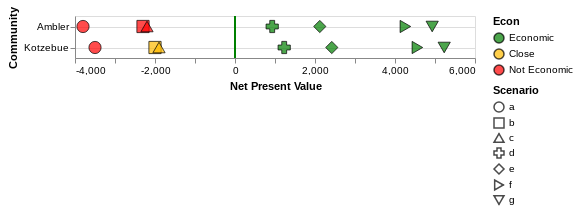

In [19]:
# make a color scale for economic payback
color_scale = alt.Scale(
            domain=['Economic', 'Close', 'Not Economic'],
            range=['green', '#FFBB00', 'red'])

main = alt.Chart(df_test).mark_point(
    size=150, opacity=0.7, stroke='black', strokeWidth=1
).encode(
    x=alt.X('Val', axis=alt.Axis(title='Net Present Value', grid=False)),
    y=alt.Y('City', axis=alt.Axis(title='Community', grid=True)),
    shape='Scenario',
    color=alt.Color('Econ', scale=color_scale),
    fill=alt.Color('Econ', scale=color_scale),
    tooltip=['Scenario']
)
rule_data = pd.DataFrame([{"ThresholdValue": 0, "Threshold": "breakeven"}])
rule = alt.Chart(rule_data).mark_rule(color='green').encode(
    x='ThresholdValue',
    size=alt.value(2)
)
(rule + main).interactive()

In [9]:
import logging
logging.root.setLevel(logging.DEBUG)
logging.root.getEffectiveLevel(), logging.DEBUG

(10, 10)